In [1]:
################## Percent SSC from River vs. Seabed ###################
# The purpose of this script is to plot the percentage of SSC
# from rivers vs. the seabed for the standard runs and the sensitivity
# test where discharge is doubled. This will be done both regardless of 
# mud class and in terms of mud class to see what makes the most sense.
# THe goal is to see if doubling the river discharge led to more
# SSC from riverine sediment,
#
# Notes:
# -
#
#########################################################################

In [2]:
# Load in the packages 
import numpy as np
import xarray as xr
import xesmf as xe
import pandas as pd
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import transforms 
from matplotlib import cm, ticker
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from glob import glob
import xroms
import cmocean
#import matplotlib.ticker as tick
#import matplotlib.patches as patches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

In [3]:
# Set a universal fontsize
fontsize = 25

# Set the tick size for all plots
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

# Prevent tick labels from overlapping
matplotlib.rcParams['xtick.major.pad'] = 12
matplotlib.rcParams['ytick.major.pad'] = 12

In [4]:
# Load in the grid
grid = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Include/KakAKgrd_shelf_big010_smooth006.nc')
#grid = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Grids/KakAKgrd_shelf_big010_smooth006.nc') # UPDATE PATH


# Pull out some dimensions
eta_rho_len = len(grid.eta_rho)
xi_rho_len = len(grid.xi_rho)
s_rho_len = int(20)
Nbed_len = 11

# Multiply by masks to make land appear 
# Make it so land will appear
temp_mask = grid.mask_rho.copy()
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)


# Load in the rho masks 
mask_rho_nan = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_ones_nans.nc') # UPDATE PATH
mask_rho_zeros = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_zeros_ones.nc')
#mask_rho_nan = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_ones_nans.nc')
#mask_rho_zeros = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_zeros_ones.nc')

## Procees the Output

### Define Functions

In [5]:
# -------------------------------------------------------------------------------------
# ----------------------- Define a Bunch o Functions ----------------------------
# -------------------------------------------------------------------------------------

# Define a function to pull out the length of time in the model run
# And the time steps
def get_model_time(filenames, num_files):
    """
    This function loops though model output and pulls
    out the entire length of the run, as well as the 
    individual time steps of the run.
    
    Inputs:
    - filenames: path and name of model output
    - num_files: the number of model output files
    
    Outputs:
    - time_len: length of time of model run (integer)
    - time_steps_list: list of time steps of full run (datetimes64)
    - time_lengths: array holding the lenght of time of each output file
    """

    # Create an array to hold the length of time in each output file
    time_lengths = np.empty((num_files))

    # Loop through output to pull out lenth of time
    for k in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[k])

        # Pull out the length of time 
        time_lengths[k] = len(model_output.ocean_time)

    # Now sum over all the lengths to get total time
    time_len = np.sum(time_lengths, axis=0)

    # Convert from float to int
    time_len = int(time_len)

    # Loop back through the output to pull out the time step and save it
    # Make a list to hold the time steps 
    time_steps_list = []
    # Loop through output
    for h in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[h])

        # Get the length of the run
        output_len = len(model_output.ocean_time)

        # Loop through each time step and append it to the list
        for g in range(output_len):
            time_steps_list.append(model_output.ocean_time[g].values)

    # Return this time length and time steps
    return(time_len, time_steps_list, time_lengths)

In [6]:
# Make a function to calculate the depth-integrated SSC and 
# depth-averaged SSC for all sediment class
def calc_depth_int_avg_ssc_seabed_river_std(file_names, time_lengths, full_time_len, eta_rho_len, xi_rho_len):
    """
    The purpose of this function is to take a given model output file, load 
    in the output, and caluclate the depth-integrated and depth-averaegd 
    suspended sediment concentrations (SSC) for seabed and river sediment classes 
    in std runs.

    Parameters
    ----------
    filename : The name/path of the model output file.

    Returns
    -------
    depth_int_ssc_allsed: Spatail time series of depth-integrated SSC for 
    all sediment classes (kg/m2)
    depth_avg_ssc_allsed: Spatial time series of depth-averaged ssc for a 
    all sediment classes (kg/m3)

    """

    # Make empty arrays to hold the time series
    # Seabed seds
    depth_int_ssc_seabed_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_seabed_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    # Seabed seds
    depth_int_ssc_river_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_river_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    
    #
    # Set a time step to track which time step the loop is on
    time_step = 0

    # Get number of files
    num_files = len(file_names)

    # Loop through the model output
    for j in range(num_files):
    #for j in range(1):

        print('j: ', j, flush=True)
        
        # Prep time for saving to arrays
        #print('time_step: ', time_step)
        #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
        start = int(time_step)
        end = int(time_step+time_lengths[j])
        print('start: ', start)
        print('end: ', end)
        
        # Load in the model output
        model_output = xr.open_dataset(file_names[j])
        
        # Pull out the sediment class of interest
        # All sed
        ssc_seabed_tmp = (model_output.sand_01 + model_output.sand_02 + model_output.sand_03 + model_output.mud_02 + model_output.mud_03 +
                        model_output.mud_04 + model_output.mud_05 + model_output.mud_06 + model_output.mud_07 + model_output.mud_08 + model_output.mud_09 +
                        model_output.mud_10 + model_output.mud_11 + model_output.mud_12 + model_output.mud_13 + model_output.mud_14)
        ssc_rivers_tmp = (model_output.mud_15 + model_output.mud_16 + model_output.mud_17 + model_output.mud_18 + model_output.mud_19 + 
                        model_output.mud_20 + model_output.mud_21 + model_output.mud_22 + model_output.mud_23 + model_output.mud_24)
        
        # To collapse to horizontal, multiply each layer by its
        # thickness
        # Calculate the time-varying thickness of the cells
        dz = abs(model_output.z_w[:,:-1,:,:].values - model_output.z_w[:,1:,:,:].values)
        
        # Calculate depth-integrated ssc
        # Seabed sed
        depth_int_ssc_seabed_seds[start:end,:,:] = (((ssc_seabed_tmp*dz)).sum(dim='s_rho'))
        # River sed
        depth_int_ssc_river_seds[start:end,:,:] = (((ssc_rivers_tmp*dz)).sum(dim='s_rho'))
        
        # Divide by bathymetry to get depth-averaged SSC (kg/m3)
        # Do this for all classes but don't return it for now? Or dooooo
        # Seabed sed
        depth_avg_ssc_seabed_seds[start:end,:,:] = depth_int_ssc_seabed_seds[start:end,:,:]/model_output.bath[:,:,:].values
        # River sed
        depth_avg_ssc_river_seds[start:end,:,:] = depth_int_ssc_river_seds[start:end,:,:]/model_output.bath[:,:,:].values
        
        # Update the base time_step
        time_step = time_step + time_lengths[j]

    
    # Return the depth-integrated and depth-averaged SSC for all variations in classes
    return(depth_int_ssc_seabed_seds, depth_avg_ssc_seabed_seds, depth_int_ssc_river_seds, depth_avg_ssc_river_seds)

In [7]:
# Make a function to calculate the depth-integrated SSC and 
# depth-averaged SSC for seabed vs. river seds in sensitivity test runs
def calc_depth_int_avg_ssc_seabed_river_sens(file_names, time_lengths, full_time_len, eta_rho_len, xi_rho_len):
    """
    The purpose of this function is to take a given model output file, load 
    in the output, and caluclate the depth-integrated and depth-averaegd 
    suspended sediment concentrations (SSC) for seabed and river sediment classes 
    in the river discharge sensitivity test run.

    Parameters
    ----------
    filename : The name/path of the model output file.

    Returns
    -------
    depth_int_ssc_allsed: Spatail time series of depth-integrated SSC for 
    all sediment classes (kg/m2)
    depth_avg_ssc_allsed: Spatial time series of depth-averaged ssc for a 
    all sediment classes (kg/m3)

    """

    # Make empty arrays to hold the time series
    # Seabed seds
    depth_int_ssc_seabed_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_seabed_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    # Seabed seds
    depth_int_ssc_river_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_river_seds = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    
    #
    # Set a time step to track which time step the loop is on
    time_step = 0

    # Get number of files
    num_files = len(file_names)

    # Loop through the model output
    for j in range(num_files):
    #for j in range(1):

        print('j: ', j, flush=True)
        
        # Prep time for saving to arrays
        #print('time_step: ', time_step)
        #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
        start = int(time_step)
        end = int(time_step+time_lengths[j])
        print('start: ', start)
        print('end: ', end)
        
        # Load in the model output
        model_output = xr.open_dataset(file_names[j])
        
        # Pull out the sediment class of interest
        # All sed
        ssc_seabed_tmp = (model_output.sand_01 + model_output.sand_02 + model_output.sand_03 + model_output.mud_01 + model_output.mud_02)
        ssc_rivers_tmp = (model_output.mud_03 + model_output.mud_04)
        
        # To collapse to horizontal, multiply each layer by its
        # thickness
        # Calculate the time-varying thickness of the cells
        dz = abs(model_output.z_w[:,:-1,:,:].values - model_output.z_w[:,1:,:,:].values)
        
        # Calculate depth-integrated ssc
        # Seabed sed
        depth_int_ssc_seabed_seds[start:end,:,:] = (((ssc_seabed_tmp*dz)).sum(dim='s_rho'))
        # River sed
        depth_int_ssc_river_seds[start:end,:,:] = (((ssc_rivers_tmp*dz)).sum(dim='s_rho'))
        
        # Divide by bathymetry to get depth-averaged SSC (kg/m3)
        # Do this for all classes but don't return it for now? Or dooooo
        # Seabed sed
        depth_avg_ssc_seabed_seds[start:end,:,:] = depth_int_ssc_seabed_seds[start:end,:,:]/model_output.bath[:,:,:].values
        # River sed
        depth_avg_ssc_river_seds[start:end,:,:] = depth_int_ssc_river_seds[start:end,:,:]/model_output.bath[:,:,:].values
        
        # Update the base time_step
        time_step = time_step + time_lengths[j]

    
    # Return the depth-integrated and depth-averaged SSC for all variations in classes
    return(depth_int_ssc_seabed_seds, depth_avg_ssc_seabed_seds, depth_int_ssc_river_seds, depth_avg_ssc_river_seds)

### Load in & Process Output

In [ ]:
# Load in/prep model output/file paths/etc

# --- Aggregated ---
# ROMS aggregated output
# dbsed0001
file_names_agg = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_*.nc')

# Sort them to be in order
file_names_agg2 = sorted(file_names_agg)
# TEMP
#file_names_agg2 = file_names_agg2[:3]

# Check to see if this worked
print(file_names_agg2[0], flush=True)
#print(file_names_agg2[1], flush=True)
#print(file_names_agg2[2], flush=True)
print(file_names_agg2[-1], flush=True)

# Pull out the number of files
num_files_agg = len(file_names_agg2)

# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Aggregated 
full_time_len_agg, time_steps_agg, time_lengths_agg = get_model_time(file_names_agg2, num_files_agg)

# --- Unaggregated ---
# Same but for unagregated
# ROMS aggregated output
# dbsed0001
file_names_unag = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_*.nc')

# Sort them to be in order
file_names_unag2 = sorted(file_names_unag)

# Check to see if this worked
print(file_names_unag2[0], flush=True)
print(file_names_unag2[1], flush=True)
print(file_names_unag2[2], flush=True)
print(file_names_unag2[-1], flush=True)

# Pull out the number of files
num_files_unag = len(file_names_unag2)

# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Unaggregated 
full_time_len_unag, time_steps_unag, time_lengths_unag = get_model_time(file_names_unag2, num_files_unag)


In [ ]:
# Get a spatial time series of total SSC - 
# both depth-integrated and depth-averaged
# Unique Aggregated run
depth_int_ssc_seabed_agg, depth_avg_ssc_seabed_agg, depth_int_ssc_rivers_agg, depth_avg_ssc_rivers_agg = calc_depth_int_avg_ssc_seabed_river_std(file_names_agg2, time_lengths_agg, full_time_len_agg, eta_rho_len, xi_rho_len)

In [ ]:
# Unique unaggregated run
depth_int_ssc_seabed_unag, depth_avg_ssc_seabed_unag, depth_int_ssc_rivers_unag, depth_avg_ssc_rivers_unag = calc_depth_int_avg_ssc_seabed_river_std(file_names_unag2, time_lengths_unag, full_time_len_unag, eta_rho_len, xi_rho_len)

In [ ]:
# Add these together to get total river and seabed for standard runs
depth_int_ssc_seabed_std = depth_int_ssc_seabed_agg + depth_int_ssc_seabed_unag
depth_avg_ssc_seabed_std = depth_avg_ssc_seabed_agg + depth_avg_ssc_seabed_unag
depth_int_scc_rivers_std = depth_int_ssc_rivers_agg + depth_int_ssc_rivers_unag
depth_avg_scc_rivers_std = depth_avg_ssc_rivers_agg + depth_avg_ssc_rivers_unag

In [ ]:
# Load in the sensitivity test
# Double discharge sensitivity test
file_names_sens = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_*.nc')

# Sort them to be in order
file_names_sens2 = sorted(file_names_sens)

# Check to see if this worked
print(file_names_sens2[0], flush=True)
print(file_names_sens2[1], flush=True)
print(file_names_sens2[2], flush=True)
print(file_names_sens2[-1], flush=True)
print('all files: ', file_names_sens2, flush=True)

# Pull out the number of files
num_files_sens = len(file_names_sens2)

# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
full_time_len_sens, time_steps_sens, time_lengths_sens = get_model_time(file_names_sens2, num_files_sens)

In [ ]:
# And run function for the sensitivity test
# Double dis run
# Unique unaggregated run
depth_int_ssc_seabed_doub_dis, depth_avg_ssc_seabed_doub_dis, depth_int_ssc_rivers_doub_dis, depth_avg_ssc_rivers_doub_dis = calc_depth_int_avg_ssc_seabed_river_sens(file_names_sens2, time_lengths_sens, full_time_len_sens, eta_rho_len, xi_rho_len)


In [ ]:
# Trim in time to the time we want
depth_int_ssc_seabed_std = depth_int_ssc_seabed_std[:738,:,:]
depth_avg_ssc_seabed_std = depth_avg_ssc_seabed_std[:738,:,:]
depth_int_ssc_river_std = depth_int_ssc_river_std[:738,:,:]
depth_avg_ssc_river_std = depth_avg_ssc_river_std[:738,:,:]
depth_int_ssc_seabed_doub_dis = depth_int_ssc_seabed_doub_dis[:738,:,:]
depth_avg_ssc_seabed_doub_dis = depth_avg_ssc_seabed_doub_dis[:738,:,:]
depth_int_ssc_river_doub_dis = depth_int_ssc_river_doub_dis[:738,:,:]
depth_avg_ssc_river_doub_dis = depth_avg_ssc_river_doub_dis[:738,:,:]

In [ ]:
# Save each of these to a netCDF

### Save to NetCDFs

In [ ]:
# ---------------------------------------------------------------------------
# ---------------------- Save to a NetCDF -----------------------------------
# ---------------------------------------------------------------------------
# Assuming this all works, save the post-processed data to
# a netCDF just in case 

# Set up the data
roms_timeseries_ssc_seabed_river_std = xr.Dataset(
    data_vars=dict(
        depth_int_ssc_seabed_std=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_seabed_std),
        depth_avg_ssc_seabed_std=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_seabed_std),
        depth_int_ssc_river_std=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_river_std),
        depth_avg_ssc_river_std=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_river_std),
        ),
    coords=dict(
        ocean_time=('ocean_time', time_steps_agg[:738]),
        eta_rho=('eta_rho', grid.eta_rho.values),
        xi_rho=('xi_rho', grid.xi_rho.values)
        ),
    attrs=dict(description='Time series of SSC in space broken down by river and seabed for output from combined unique aggregated and unaggregated mud model runs')) 
# Add more metadata?
roms_timeseries_ssc_seabed_river_std.depth_int_ssc_seabed_std.name='spatial time series of depth-integrated SSC for seabed seds'
roms_timeseries_ssc_seabed_river_std.depth_avg_ssc_seabed_std.name='spatial time series of depth-averaged SSC for seabed seds'
roms_timeseries_ssc_seabed_river_std.depth_int_ssc_river_std.name='spatial time series of depth-integrated SSC for river seds'
roms_timeseries_ssc_seabed_river_std.depth_avg_ssc_river_std.name='spatial time series of depth-averaged SSC for river seds'

# Save to a netcdf
#roms_timeseries_ssc_seabed_river_std.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_seabed_river_std_runs.nc')

print('Done saving to NetCDF 1', flush=True)

In [ ]:
# Set up the data
roms_timeseries_ssc_seabed_river_doub_dis = xr.Dataset(
    data_vars=dict(
        depth_int_ssc_seabed_doub_dis=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_seabed_doub_dis),
        depth_avg_ssc_seabed_doub_dis=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_seabed_doub_dis),
        depth_int_ssc_river_doub_dis=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_river_doub_dis),
        depth_avg_ssc_river_doub_dis=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_river_doub_dis),
        ),
    coords=dict(
        ocean_time=('ocean_time', time_steps_agg[:738]),
        eta_rho=('eta_rho', grid.eta_rho.values),
        xi_rho=('xi_rho', grid.xi_rho.values)
        ),
    attrs=dict(description='Time series of SSC in space broken down by river and seabed for output from double discharge river sensitivity model run')) 
# Add more metadata?
roms_timeseries_ssc_seabed_river_doub_dis.depth_int_ssc_seabed_doub_dis.name='spatial time series of depth-integrated SSC for seabed seds'
roms_timeseries_ssc_seabed_river_doub_dis.depth_avg_ssc_seabed_doub_dis.name='spatial time series of depth-averaged SSC for seabed seds'
roms_timeseries_ssc_seabed_river_doub_dis.depth_int_ssc_river_doub_dis.name='spatial time series of depth-integrated SSC for river seds'
roms_timeseries_ssc_seabed_river_doub_dis.depth_avg_ssc_river_doub_dis.name='spatial time series of depth-averaged SSC for river seds'

# Save to a netcdf
#roms_timeseries_ssc_seabed_river_doub_dis.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_seabed_river_doub_dis_run.nc')

print('Done saving to NetCDF 2', flush=True)

In [ ]:
# Get time series of depth-integrated SSC in all space
# for total, then for riverine seds, then for seabed seds

# Do this for both standard runs and river sensitivty run
# Need to ignore the non-unique class in standard runs and instead
# add together the unique class from rivers from the two runs
# to get total riverine unaggregated and aggregated and do the 
# same for seabed to get full seabed (or could do it by class
# but I think that is more detail than we need)

# Then get percentages and plot as box and whisker? and ignore
# mud class but rather focus on river vs. seabed?

In [ ]:
# so process this in another script and then come here, load in processed
# data, and then plot it somehow (maybe box and whiskers comparing the two runs
# so similar to before but different content)

## Plot the Results  
Since the post-processing above needs to be done in the *.py version of this script and submitted as a batch job, this section loads in the post-processed data and then plots it.

In [8]:
# Load in the post-processed data
seabed_riv_sed_std = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_seabed_river_std_runs.nc')
seabed_riv_sed_doub_dis = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_seabed_river_doub_dis_run.nc')

In [9]:
# Mask and sum over space
# Multiply by mask
# Standard
depth_int_ssc_seabed_std_mask = seabed_riv_sed_std.depth_int_ssc_seabed_std*mask_rho_nan.nudge_mask_rho_nan
depth_int_ssc_rivers_std_mask = seabed_riv_sed_std.depth_int_ssc_rivers_std*mask_rho_nan.nudge_mask_rho_nan
# Double discharge
depth_int_ssc_seabed_doub_dis_mask = seabed_riv_sed_doub_dis.depth_int_ssc_seabed_doub_dis*mask_rho_nan.nudge_mask_rho_nan
depth_int_ssc_rivers_doub_dis_mask = seabed_riv_sed_doub_dis.depth_int_ssc_rivers_doub_dis*mask_rho_nan.nudge_mask_rho_nan

# Sum over space
# Standard
depth_int_ssc_seabed_std_mask_sum = np.nansum(depth_int_ssc_seabed_std_mask, axis=(1,2))
depth_int_ssc_rivers_std_mask_sum = np.nansum(depth_int_ssc_rivers_std_mask, axis=(1,2))
# Double discharge
depth_int_ssc_seabed_doub_dis_mask_sum = np.nansum(depth_int_ssc_seabed_doub_dis_mask, axis=(1,2))
depth_int_ssc_rivers_doub_dis_mask_sum = np.nansum(depth_int_ssc_rivers_doub_dis_mask, axis=(1,2))


In [10]:
# Take the percentages to get time series of percent
# Standard
percent_river_sed_std = depth_int_ssc_rivers_std_mask_sum/(depth_int_ssc_seabed_std_mask_sum + depth_int_ssc_rivers_std_mask_sum)
# Double discharge 
percent_river_sed_doub_dis = depth_int_ssc_rivers_doub_dis_mask_sum/(depth_int_ssc_seabed_doub_dis_mask_sum + depth_int_ssc_rivers_doub_dis_mask_sum)

/projects/brun1463/code-server/tmp/ipykernel_2568426/1399223714.py:3: RuntimeWarning: invalid value encountered in divide
  percent_river_sed_std = depth_int_ssc_rivers_std_mask_sum/(depth_int_ssc_seabed_std_mask_sum + depth_int_ssc_rivers_std_mask_sum)
/projects/brun1463/code-server/tmp/ipykernel_2568426/1399223714.py:5: RuntimeWarning: invalid value encountered in divide
  percent_river_sed_doub_dis = depth_int_ssc_rivers_doub_dis_mask_sum/(depth_int_ssc_seabed_doub_dis_mask_sum + depth_int_ssc_rivers_doub_dis_mask_sum)


Text(0, 0.5, 'Depth-Integrated SSC (kg/m³)')

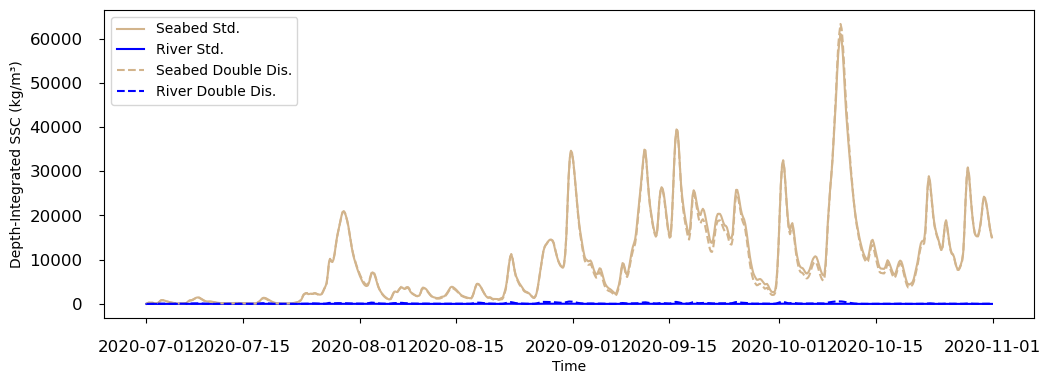

In [11]:
# Plot a time series of the different values
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(seabed_riv_sed_std.ocean_time, np.nansum((seabed_riv_sed_std.depth_int_ssc_seabed_std*mask_rho_nan.nudge_mask_rho_nan), axis=(1,2)), color='tan', label='Seabed Std.')
ax.plot(seabed_riv_sed_std.ocean_time, np.nansum((seabed_riv_sed_std.depth_int_ssc_rivers_std*mask_rho_nan.nudge_mask_rho_nan), axis=(1,2)), color='blue', label='River Std.')

ax.plot(seabed_riv_sed_doub_dis.ocean_time, np.nansum((seabed_riv_sed_doub_dis.depth_int_ssc_seabed_doub_dis*mask_rho_nan.nudge_mask_rho_nan), axis=(1,2)), color='tan', label='Seabed Double Dis.', linestyle='--')
ax.plot(seabed_riv_sed_doub_dis.ocean_time, np.nansum((seabed_riv_sed_doub_dis.depth_int_ssc_rivers_doub_dis*mask_rho_nan.nudge_mask_rho_nan), axis=(1,2)), color='blue', label='River Double Dis.', linestyle='--')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Depth-Integrated SSC (kg/m\u00b3)')

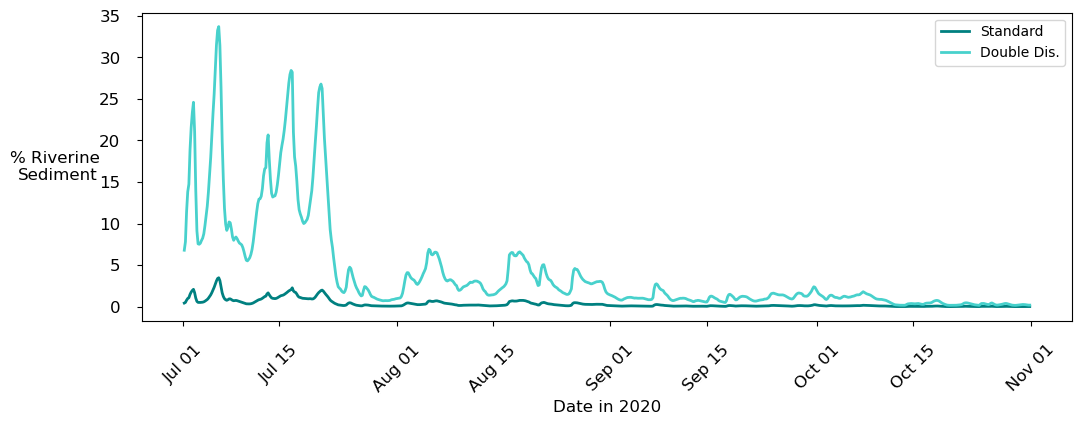

In [12]:
# Plot time series of percentages 
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(seabed_riv_sed_std.ocean_time, percent_river_sed_std*100, color='teal', label='Standard', linewidth=2)
ax.plot(seabed_riv_sed_doub_dis.ocean_time, percent_river_sed_doub_dis*100, color='mediumturquoise', label='Double Dis.', linewidth=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.tick_params(axis='x', labelrotation=45)

ax.set_xlabel('Date in 2020', fontsize=fontsize-13)
ax.set_ylabel('% Riverine \nSediment', rotation=0, va='center', labelpad=30, fontsize=fontsize-13)
ax.legend()

In [11]:
# Do a similar plot but box and whiskers 
# Prep the data to work well

Text(0.64, 0.02, 'Double Dis.')

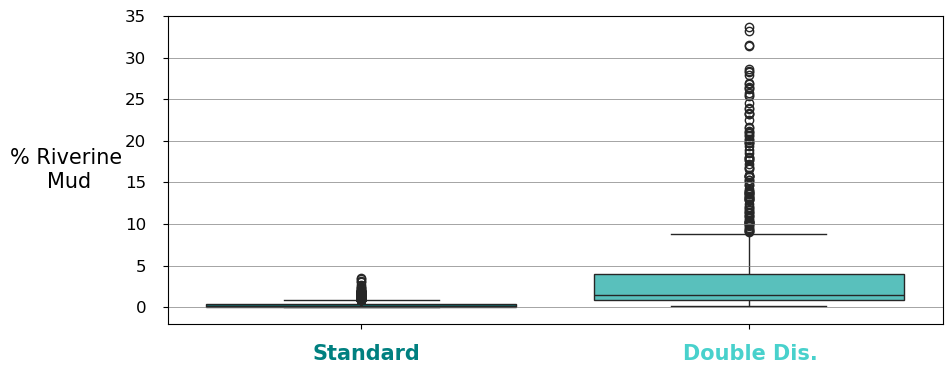

In [13]:
# Set subplot labels 
#subplot_titles = ['30 - 60 m', '20 - 30 m', '10 - 20 m', '0 - 10 m']

# Make a palette
river_palette_std_double = ['teal', 'mediumturquoise']

# Make the figure 
fig2, ax2 = plt.subplots(figsize=(10,4)) # 18, 8

# Plot the data as a boxplot
s8 = sns.boxplot(data=[percent_river_sed_std*100, percent_river_sed_doub_dis*100],  palette=river_palette_std_double)
#s9 = sns.boxplot(data=percent_river_sed_doub_dis, color=river_palette_std_double[1])


# Set y-axis label
ax2.set_ylabel('% Riverine \nMud', fontsize=fontsize-10, rotation=0, va='center', labelpad=40)

# Set the y-limit
ax2.set_ylim(-2,35) # (-10,110)

# Add bars for 25, 50, 75 percent
ax2.axhline(y=0, linestyle='-', color='gray', linewidth=0.5)
ax2.axhline(y=5, linestyle='-', color='gray', linewidth=0.5)
ax2.axhline(y=10, linestyle='-', color='gray', linewidth=0.5)
ax2.axhline(y=15, linestyle='-', color='gray', linewidth=0.5)
ax2.axhline(y=20, linestyle='-', color='gray', linewidth=0.5)
ax2.axhline(y=25, linestyle='-', color='gray', linewidth=0.5)
ax2.axhline(y=30, linestyle='-', color='gray', linewidth=0.5)

# Adjust the spacing 
#fig2.subplots_adjust(hspace=0.30)
#ax2.legend()
ax2.set_xlabel('')
plt.setp(ax2.get_xticklabels(), visible=False)

# Manually place section labels 
fig2.text(0.27, 0.02, 'Standard', color=river_palette_std_double[0], fontsize=fontsize-10, weight='bold')
fig2.text(0.64, 0.02, 'Double Dis.', color=river_palette_std_double[1], fontsize=fontsize-10, weight='bold')


Text(0.129, 0.34, 'b)')

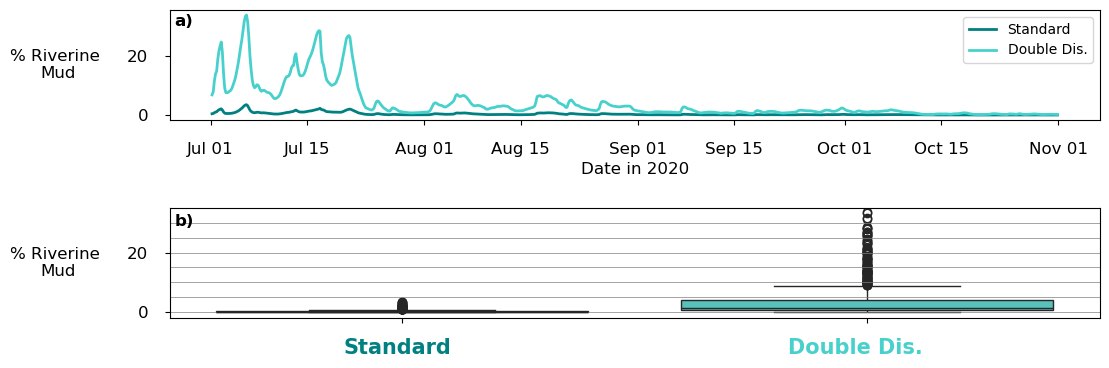

In [34]:
# Make a combined version of the plots

# Make the figure
fig, ax = plt.subplots(2, figsize=(12,4))

# Plot time series of percentages 
ax[0].plot(seabed_riv_sed_std.ocean_time, percent_river_sed_std*100, color='teal', label='Standard', linewidth=2)
ax[0].plot(seabed_riv_sed_doub_dis.ocean_time, percent_river_sed_doub_dis*100, color='mediumturquoise', label='Double Dis.', linewidth=2)

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[0].tick_params(axis='x', labelrotation=0) #labelrotation=45

ax[0].set_xlabel('Date in 2020', fontsize=fontsize-13)
ax[0].set_ylabel('% Riverine \nMud', rotation=0, va='center', labelpad=50, fontsize=fontsize-13)
ax[0].legend()


# Plot the data as a boxplot
s8 = sns.boxplot(data=[percent_river_sed_std*100, percent_river_sed_doub_dis*100],  ax=ax[1], palette=river_palette_std_double)
#s9 = sns.boxplot(data=percent_river_sed_doub_dis, color=river_palette_std_double[1])


# Set y-axis label
ax[1].set_ylabel('% Riverine \nMud', fontsize=fontsize-13, rotation=0, va='center', labelpad=50)

# Set the y-limit
ax[1].set_ylim(-2,35) # (-10,110)

# Add bars for 25, 50, 75 percent
ax[1].axhline(y=0, linestyle='-', color='gray', linewidth=0.5)
ax[1].axhline(y=5, linestyle='-', color='gray', linewidth=0.5)
ax[1].axhline(y=10, linestyle='-', color='gray', linewidth=0.5)
ax[1].axhline(y=15, linestyle='-', color='gray', linewidth=0.5)
ax[1].axhline(y=20, linestyle='-', color='gray', linewidth=0.5)
ax[1].axhline(y=25, linestyle='-', color='gray', linewidth=0.5)
ax[1].axhline(y=30, linestyle='-', color='gray', linewidth=0.5)

# Adjust the spacing 
#fig2.subplots_adjust(hspace=0.30)
#ax2.legend()
ax[1].set_xlabel('')
plt.setp(ax[1].get_xticklabels(), visible=False)

# Manually place section labels 
fig.text(0.27, 0.02, 'Standard', color=river_palette_std_double[0], fontsize=fontsize-10, weight='bold')
fig.text(0.64, 0.02, 'Double Dis.', color=river_palette_std_double[1], fontsize=fontsize-10, weight='bold')

plt.subplots_adjust(hspace=0.8)

# Add subplot labels
fig.text(0.129, 0.840, 'a)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.129, 0.340, 'b)', color='black', fontsize=fontsize-13, weight='bold')


In [13]:
# Print a bunch of stats
# Standard
mean_percent_ssc_river_sed_std = np.nanmean(percent_river_sed_std)
print('mean percent SSC river sed std: ', mean_percent_ssc_river_sed_std*100)
stddev_percent_ssc_river_sed_std = np.nanstd(percent_river_sed_std)
print('std dev percent SSC river sed std: ', stddev_percent_ssc_river_sed_std*100)
# Double Discharge 
mean_percent_ssc_river_sed_doub_dis = np.nanmean(percent_river_sed_doub_dis)
print('mean percent SSC river sed doub dis: ', mean_percent_ssc_river_sed_doub_dis*100)
stddev_percent_ssc_river_sed_doub_dis = np.nanstd(percent_river_sed_doub_dis)
print('std dev percent SSC river sed doub dis: ', stddev_percent_ssc_river_sed_doub_dis*100)

#percent_river_sed_std*100, percent_river_sed_doub_dis*100

mean percent SSC river sed std:  0.3406730323456247
std dev percent SSC river sed std:  0.4932397011160775
mean percent SSC river sed doub dis:  4.079631254084582
std dev percent SSC river sed doub dis:  6.012733452538585


In [17]:
seabed_riv_sed_std.ocean_time[-5:-1].values

array(['2020-10-31T05:00:00.000000000', '2020-10-31T09:00:00.000000000',
       '2020-10-31T13:00:00.000000000', '2020-10-31T17:00:00.000000000'],
      dtype='datetime64[ns]')

In [19]:
# Find the correlation with river discharge 
# Load in the river forcing file
river_frc = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Include/river_forcing_file_beaufort_shelf_10rivs_13seabed_blaskey_data_sagDSS3_rating_001.nc')

In [20]:
tot_river_dis = river_frc.river_transport.sum(dim='river')

In [21]:
tot_river_dis

<xarray.DataArray 'river_transport' (river_time: 125)> Size: 1kB
array([2589.187862  , 2791.172246  , 2815.267166  , 2625.413937  ,
       2325.0757768 , 2011.2983248 , 1739.1164787 , 1514.52450367,
       1330.50403596, 1179.44442612, 1051.48622051,  958.21649006,
        957.1037391 , 1035.0342541 , 1114.9800986 , 1135.334061  ,
       1112.5688487 , 1098.1854901 , 1083.31357149, 1021.20717828,
        916.47359758,  814.94989292,  828.9177493 ,  997.977577  ,
       1159.814555  , 1220.2708387 , 1454.174537  , 1827.425747  ,
       2130.606255  , 2314.9695023 , 2395.652119  , 2384.389997  ,
       2337.085128  , 2284.69046   , 2185.762325  , 2063.880354  ,
       1947.2546335 , 1833.3312216 , 1736.8839589 , 1670.779336  ,
       1612.3047247 , 1552.1017144 , 1498.5392833 , 1447.543103  ,
       1379.8776522 , 1293.7741597 , 1200.3834455 , 1105.7797271 ,
       1018.9376475 ,  944.08399994,  881.6586247 ,  832.9943081 ,
        796.21093575,  768.2352733 ,  757.0134582 ,  787.5509626 ,
        825.7679455 ,  848.8568177 ,  880.3024485 ,  922.65135356,
        944.5111724 ,  938.00350256,  926.001675  ,  904.82600125,
        874.8979798 ,  845.40574594,  828.41396796,  818.2149136 ,
        819.8085201 ,  938.6901903 , 1076.76263   , 1158.744162  ,
       1251.9731802 , 1278.7545358 , 1214.879586  , 1126.301262  ,
       1050.8270353 , 1064.772962  , 1104.270222  , 1194.151308  ,
       1296.757009  , 1330.824249  , 1286.178229  , 1206.5385648 ,
       1099.1287116 ,  972.6236886 ,  881.56302   ,  844.6268074 ,
        832.112454  ,  812.9855984 ,  780.524643  ,  740.324206  ,
        721.3561897 ,  794.606751  , 1001.265216  , 1317.076534  ,
       1607.820098  , 1786.838094  , 1824.4822584 , 1717.9144433 ,
       1505.3015723 , 1236.76990093,  956.74466636,  698.90478568,
        484.29468174,  320.70035409,  206.70623762,  133.54448769,
         89.39108076,   63.96621973,   49.57883613,   41.32081234,
         36.35456501,   33.56520415,   32.40917489,   31.45208154,
         29.83064462,   27.80062652,   25.57956887,   24.30864882,
         24.18512675,   23.63918337,   22.16857962,   20.5223898 ,
         19.50686734])
Coordinates:
  * river_time  (river_time) datetime64[ns] 1kB 2020-07-01T01:00:00 ... 2020-...
Attributes:
    long_name:  river runoff vertically integrated mass transport
    units:      meter3 second-1
    positive:   LuvSrc=T flow in positive u,v direction, LwSrc=T flow into gr...
    negative:   LuvSrc=T flow in negative u,v direction, LwSrc=T flow out of ...
    time:       river_time

In [34]:
len(tot_river_dis)

125

In [36]:
river_frc.river_time[-1].values

np.datetime64('2020-11-02T01:00:00.000000000')

In [30]:
# Need to resample the post-processed model
# output to be daily in order to get correlations
percent_river_sed_std_xr = xr.DataArray(percent_river_sed_std, coords={"ocean_time": seabed_riv_sed_std.ocean_time}, dims=['ocean_time']).to_dataset(name='percent_river_sed_std')
percent_river_sed_std_daily = percent_river_sed_std_xr.percent_river_sed_std.resample(ocean_time='D').mean()
percent_river_sed_doub_dis_xr = xr.DataArray(percent_river_sed_doub_dis, coords={"ocean_time": seabed_riv_sed_doub_dis.ocean_time}, dims=['ocean_time']).to_dataset(name='percent_river_sed_doub_dis')
percent_river_sed_doub_dis_daily = percent_river_sed_doub_dis_xr.percent_river_sed_doub_dis.resample(ocean_time='D').mean()
#percent_river_sed_doub_dis_daily = percent_river_sed_doub.resample(ocean_time='D').mean()


In [32]:
percent_river_sed_doub_dis_daily

<xarray.DataArray 'percent_river_sed_doub_dis' (ocean_time: 123)> Size: 984B
array([0.10918825, 0.20574906, 0.080093  , 0.11852651, 0.24572411,
       0.26656959, 0.10130431, 0.08425127, 0.07374293, 0.0583341 ,
       0.09613693, 0.14290874, 0.17300291, 0.14018124, 0.19818658,
       0.26814281, 0.15933073, 0.10433811, 0.12673205, 0.22520553,
       0.2171586 , 0.09231269, 0.03024911, 0.02180932, 0.04057473,
       0.01879747, 0.02052487, 0.01304908, 0.00842913, 0.00722203,
       0.00856348, 0.01147209, 0.03538034, 0.03191992, 0.03238398,
       0.05708452, 0.06412148, 0.04953189, 0.03205377, 0.02726105,
       0.02185062, 0.0273242 , 0.030317  , 0.02351201, 0.01434493,
       0.01647669, 0.02371098, 0.05545719, 0.06312654, 0.05975606,
       0.04417996, 0.03125912, 0.04482937, 0.02970676, 0.02120452,
       0.01582353, 0.03011757, 0.04056823, 0.03028571, 0.02828131,
       0.03006049, 0.01858578, 0.01235158, 0.00850999, 0.01059764,
       0.0106043 , 0.01012071, 0.00870511, 0.02023918, 0.02042287,
       0.01164755, 0.00816454, 0.0100518 , 0.00809206, 0.00694764,
       0.00635929, 0.01032725, 0.00910102, 0.00590409, 0.0133022 ,
       0.00973319, 0.01216265, 0.00844599, 0.00738019, 0.00910668,
       0.01484518, 0.01451609, 0.01257588, 0.01054573, 0.01581212,
       0.0132108 , 0.02085793, 0.01473055, 0.01064411, 0.01226695,
       0.01093132, 0.01177163, 0.01318863, 0.01610279, 0.01479948,
       0.01029721, 0.00847301, 0.00574437, 0.00234081, 0.00174914,
       0.00348772, 0.00359407, 0.00331289, 0.00489522, 0.0069713 ,
       0.00324591, 0.00167385, 0.00196077, 0.00403852, 0.00311082,
       0.00230761, 0.00319015, 0.00340833, 0.00231464, 0.00350936,
       0.00188246, 0.00226354, 0.00216983])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 984B 2020-07-01 ... 2020-10-31

In [37]:
# Find the correlations 
corr_coeff_riv_dis_ssc_riv_sed_std, pvalue_riv_dis_ssc_riv_sed_std = pearsonr(percent_river_sed_std_daily, tot_river_dis[:-2])
print('Pearson r correlation coeff. river dis. and percent shelf SSC riverine (std): ', corr_coeff_riv_dis_ssc_riv_sed_std)
corr_coeff_riv_dis_ssc_riv_sed_doub_dis, pvalue_riv_dis_ssc_riv_sed_doub_dis = pearsonr(percent_river_sed_doub_dis_daily, tot_river_dis[:-2])
print('Pearson r correlation coeff. river dis. and percent shelf SSC riverine (doub_dis): ', corr_coeff_riv_dis_ssc_riv_sed_doub_dis)

Pearson r correlation coeff. river dis. and percent shelf SSC riverine (std):  0.3381451617024991
Pearson r correlation coeff. river dis. and percent shelf SSC riverine (doub_dis):  0.32693238826288706
